In [2]:
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import psycopg2
import numpy as np
from psycopg2.extras import execute_values
from faiss import read_index
import pandas as pd
import seaborn as sns

# Cargar modelo e indice

In [3]:
model = Doc2Vec.load("python.doc")
index = read_index("python.index")

# Traer nuevas preguntas

In [4]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1", port="63333", database="stack_overflow")

In [16]:
MIN_ANSWERS = 9
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 3000""")
        posts = cursor.fetchall()

# Encontrar las preguntas cercanas y sus vectores de distancia

In [17]:
posts_vectors=[]
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(model.infer_vector(simple_preprocess(post_text)))

In [18]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(1371, 50)

In [58]:
N_SIMILAR_QUESTIONS = 500
distances, similar_questions = index.search(posts_vectors, N_SIMILAR_QUESTIONS)
similar_questions.shape

(1371, 500)

In [59]:
missing_vectors = 0
features_df = []
exact_distances = []
for p_id, p_vector, similar_qs in zip(posts_ids, posts_vectors, similar_questions):
    for idx, s_q in enumerate(similar_qs):
        try:
            sq_vector = model.dv[str(s_q)]
            features_df.append([p_id, s_q, p_vector-sq_vector])
            exact_distances.append(np.linalg.norm(p_vector-sq_vector))
        except KeyError:
            missing_vectors +=1

features_df = pd.DataFrame(features_df, columns=["q_id", "sq_id", "X"])
features_df.head()

,q_id,sq_id,X
0,1854,1854,"[0.649378, 0.2630664, 0.44672212, 0.15883332, ..."
1,1854,67103056,"[0.67251927, 1.6748271, 0.80690515, 0.66100645..."
2,1854,4813238,"[0.5894268, 1.4415798, 0.7403469, 0.75718874, ..."
3,1854,67755168,"[0.13446558, 1.6254895, 0.769534, 0.75728595, ..."
4,1854,6586412,"[0.59725505, 1.1786168, 0.7956456, 0.93166816,..."


In [60]:
missing_vectors, len(features_df)

(0, 685500)

# Traer usuarios candidatos a partir de las respuestas aceptadas

In [61]:
with connection:
    with connection.cursor() as cursor:
        execute_values(cursor, """select q_id, sq_id, q_a.owner_user_id, q_a.score
                                FROM (VALUES %s) AS base_questions (q_id, sq_id)
                                JOIN posts_19 q_a ON q_a.parent_id = q_id
                                JOIN posts_19 sq ON sq.id = sq_id
                                JOIN posts_19 sq_a ON sq_a.id = sq.accepted_answer_id
                                WHERE sq_a.owner_user_id=q_a.owner_user_id""",
                                features_df[["q_id", "sq_id"]].values.tolist(), page_size=685500)
        q_ds = cursor.fetchall()
        q_ds = pd.DataFrame(q_ds, columns=["q_id", "sq_id", "user_id", "score"])
q_ds.head()

,q_id,sq_id,user_id,score
0,1345827,1345827,12855,502
1,775049,1345827,12855,1109
2,761804,761804,9493,1964
3,265960,761804,9493,1216
4,11350770,55696209,4909087,284


In [62]:
print(len(q_ds))
q_ds.head(10)

1539


,q_id,sq_id,user_id,score
0,1345827,1345827,12855,502
1,775049,1345827,12855,1109
2,761804,761804,9493,1964
3,265960,761804,9493,1216
4,11350770,55696209,4909087,284
5,6996603,6996603,21886,4529
6,5424716,5424716,9453,298
7,5946236,5946236,484293,61
8,6578986,6578986,1152127,160
9,54351852,55896204,8841057,39


### Use doc2vec similarity search

In [54]:
features_df = []
missing_vectors=0
for post_id in posts_ids:
    try:
        features_df.extend([(post_id, int(id)) for id, _ in model.dv.most_similar(model.dv[str(post_id)],topn=200)])
    except KeyError:
        missing_vectors +=1

features_df = pd.DataFrame(features_df, columns=["q_id", "sq_id"])

In [55]:
missing_vectors, len(features_df)

(0, 274200)

In [56]:
with connection:
    with connection.cursor() as cursor:
        execute_values(cursor, """select q_id, sq_id, q_a.owner_user_id, q_a.score
                                FROM (VALUES %s) AS base_questions (q_id, sq_id)
                                JOIN posts_19 q_a ON q_a.parent_id = q_id
                                JOIN posts_19 sq ON sq.id = sq_id
                                JOIN posts_19 sq_a ON sq_a.id = sq.accepted_answer_id
                                WHERE sq_a.owner_user_id=q_a.owner_user_id""",
                                features_df[["q_id", "sq_id"]].values.tolist(), page_size=685500)
        q_ds = cursor.fetchall()
        q_ds = pd.DataFrame(q_ds, columns=["q_id", "sq_id", "user_id", "score"])
q_ds.head()

,q_id,sq_id,user_id,score
0,1854,1854,2089740,1161
1,3061,3061,363,2763
2,3061,63839721,5532667,8
3,22676,22676,1595,541
4,32899,32899,3448,271


In [57]:
print(len(q_ds))
q_ds.head(10)

1178


,q_id,sq_id,user_id,score
0,1854,1854,2089740,1161
1,3061,3061,363,2763
2,3061,63839721,5532667,8
3,22676,22676,1595,541
4,32899,32899,3448,271
5,34439,34439,3394,709
6,36901,36901,720,3034
7,36901,63072026,7954504,47
8,38987,38987,541136,8482
9,42950,42950,1199,1401


## Faiss similar questions distances distribution

In [37]:
exact_distances = np.array(exact_distances)
exact_distances.mean(), exact_distances.std()

(7.8874907, 1.7196511)

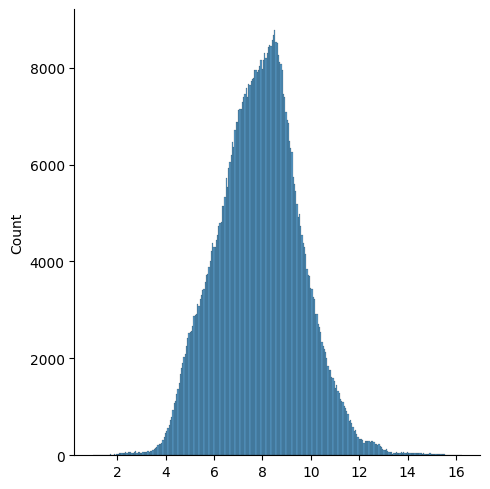

In [39]:
sns.displot(exact_distances)

In [40]:
len(exact_distances)

685500